#### Se importan las librerías a utilizar


In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


## 1.-
#### Lectura y limpieza de datos

In [ ]:
#Lectura del Dataframe
df= pd.read_csv('../../data/machine_failure_data.csv')

In [203]:
#limpieza de datos
variables = df.columns.values.tolist() #visualizamos los nombres de las variables
print(variables)
def contador_nulos(columnas):
    return columnas.isnull().sum()          #analizamos cuales datos tienen mayor cantidad de errores o nulos
for columnas in variables:
    a = contador_nulos(df[columnas])
    if contador_nulos(df[columnas])/len(df[columnas]) > 0.35:
        print(a/len(df[columnas]), 'porcentaje de nulos')
        print(f"-------la variable {columnas} tiene un alto porcentaje de valores nulos-------")
total_data_len=len(df['Date'])


['Date', 'Location', 'Min_Temp', 'Max_Temp', 'Leakage', 'Evaporation', 'Electricity', 'Parameter1_Dir', 'Parameter1_Speed', 'Parameter2_9am', 'Parameter2_3pm', 'Parameter3_9am', 'Parameter3_3pm', 'Parameter4_9am', 'Parameter4_3pm', 'Parameter5_9am', 'Parameter5_3pm', 'Parameter6_9am', 'Parameter6_3pm', 'Parameter7_9am', 'Parameter7_3pm', 'Failure_today']
0.42789026182723483 porcentaje de nulos
-------la variable Evaporation tiene un alto porcentaje de valores nulos-------
0.47692924405561454 porcentaje de nulos
-------la variable Electricity tiene un alto porcentaje de valores nulos-------
0.3773533155640573 porcentaje de nulos
-------la variable Parameter6_9am tiene un alto porcentaje de valores nulos-------
0.4015246882757942 porcentaje de nulos
-------la variable Parameter6_3pm tiene un alto porcentaje de valores nulos-------


In [204]:
df.dropna(inplace=True) #eliminar filas con valores nulos
print('la cantidad de datos usables es:', len(df['Date'])/total_data_len*100,'%')


la cantidad de datos usables es: 39.67846518464341 %


#### transformación de variables que representan el sentido del viento en un esquema de seno y coseno

In [205]:
df['Failure_today'] = df['Failure_today'].map({'No': 0, 'Yes': 1}) #mapear valores de la columna Failure_today
direccion_en_grados = {'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, #transformar direcciones a grados
              'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
              'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
              'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5}

df['Parameter1_Dir'] = df['Parameter1_Dir'].map(direccion_en_grados)
df['Parameter2_9am'] = df['Parameter2_9am'].map(direccion_en_grados)
df['Parameter2_3pm'] = df['Parameter2_3pm'].map(direccion_en_grados)

# Lista de columnas de dirección
dir_cols = ['Parameter1_Dir', 'Parameter2_9am', 'Parameter2_3pm']

for col in dir_cols:
    # Convierte a radianes
    df[f'{col}_rad'] = np.deg2rad(df[col])
    # Calcula seno y coseno
    df[f'{col}_sin'] = np.sin(df[f'{col}_rad'])
    df[f'{col}_cos'] = np.cos(df[f'{col}_rad'])


## distribución de los sentidos del vientos para parametros 1 y 2

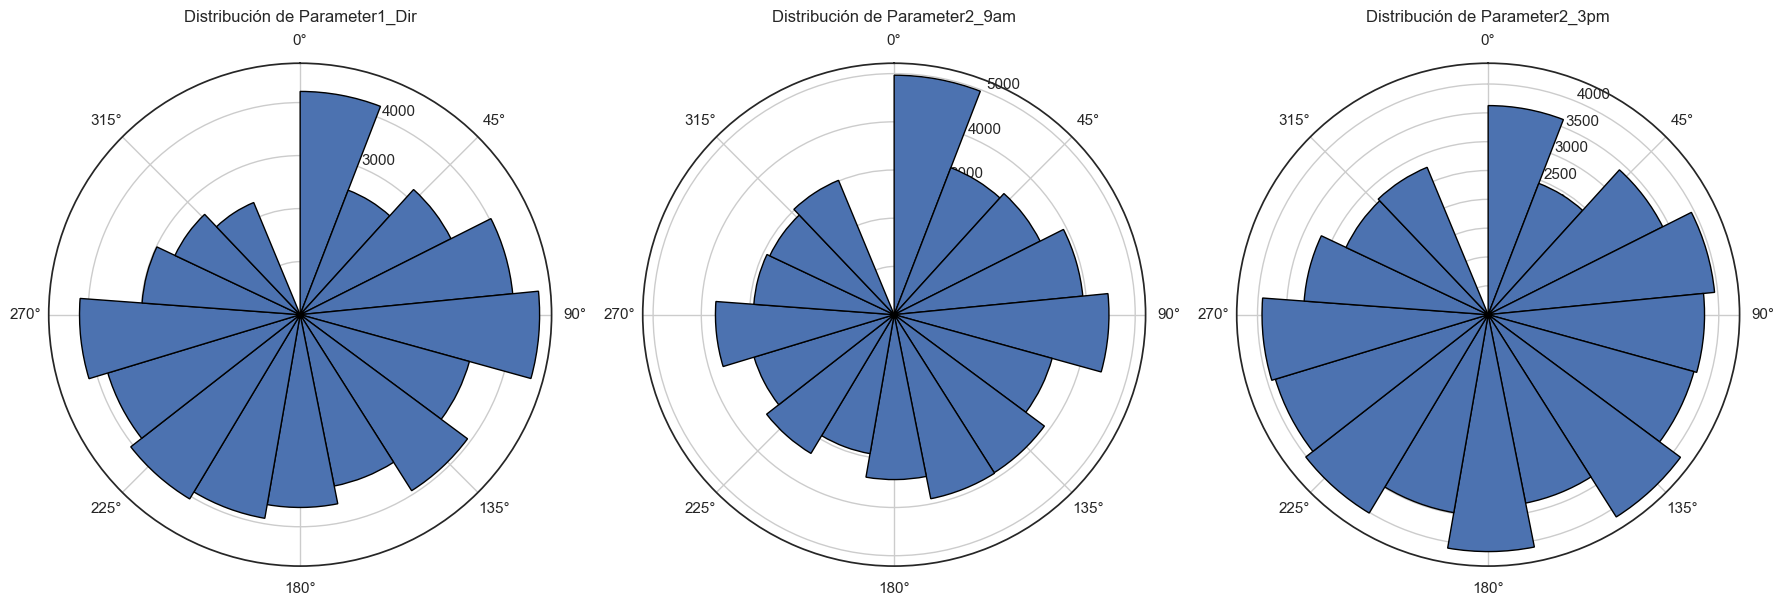

In [206]:
param_cols = [
    ('Parameter1_Dir_rad', 'Parameter1_Dir'),
    ('Parameter2_9am_rad', 'Parameter2_9am'),
    ('Parameter2_3pm_rad', 'Parameter2_3pm')
]
titulos = [
    'Distribución de Parameter1_Dir',
    'Distribución de Parameter2_9am',
    'Distribución de Parameter2_3pm'
]

# Crear la figura y los subplots polares
fig, axs = plt.subplots(1, 3, subplot_kw=dict(polar=True), figsize=(18, 6))

for i, (col_rad, col_name) in enumerate(param_cols):
    direcciones_radianes = df[col_rad]
    frecuencias, bins = np.histogram(direcciones_radianes, bins=16)
    axs[i].bar(bins[:-1], frecuencias, width=np.diff(bins), align='edge', edgecolor='black')
    axs[i].set_theta_zero_location("N")
    axs[i].set_theta_direction(-1)
    axs[i].set_title(titulos[i], va='bottom')

plt.tight_layout()
plt.show()

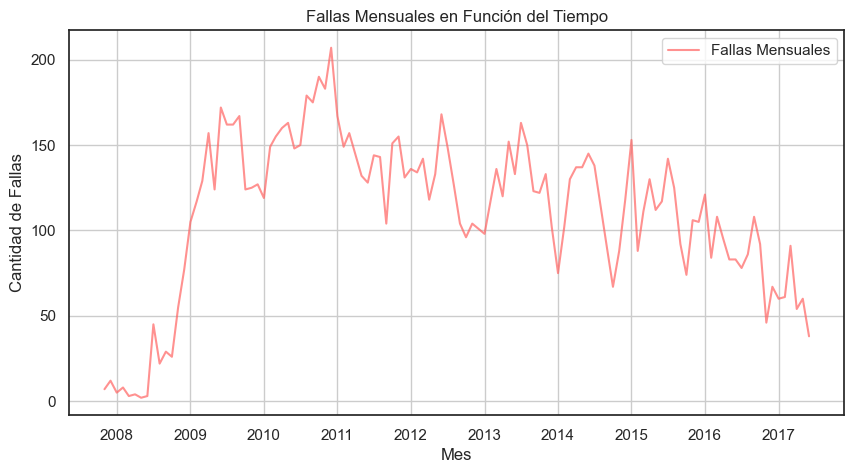

In [207]:
# Asegúrate de que 'Date' es datetime
df['Date'] = pd.to_datetime(df['Date'])

# Agrupar por semanas y calcular la suma de fallas semanales
df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
fallas_semanales = df.groupby('Week')['Failure_today'].sum().reset_index()

# Agrupar por meses y calcular la suma de fallas mensuales
df['Month'] = df['Date'].dt.to_period('M').apply(lambda r: r.start_time)
fallas_mensuales = df.groupby('Month')['Failure_today'].sum().reset_index()

# Graficar las fallas mensuales
plt.figure(figsize=(10,5))
plt.plot(fallas_mensuales['Month'], fallas_mensuales['Failure_today'], label='Fallas Mensuales', color='#ff6361', alpha=0.7)
plt.xlabel('Mes')
plt.ylabel('Cantidad de Fallas')
plt.title('Fallas Mensuales en Función del Tiempo')
plt.legend()
plt.grid(True)
plt.show()

#### Exploración de los datos 

In [208]:
dfrelevante = df[['Min_Temp', 'Max_Temp','Evaporation', 'Electricity', 'Parameter1_Speed', 'Parameter1_Dir_sin', 'Parameter1_Dir_cos', 'Parameter2_9am_sin', 'Parameter2_9am_cos', 'Parameter2_3pm_sin', 'Parameter2_3pm_cos',
                  'Parameter3_9am', 'Parameter3_3pm', 'Parameter4_9am', 'Parameter4_3pm', 'Parameter5_9am', 'Parameter5_3pm','Parameter6_9am', 'Parameter6_3pm','Parameter7_9am','Parameter7_3pm', 'Failure_today','Leakage','Date']]

print(dfrelevante.describe()) #estadisticas descriptivas de los datos


           Min_Temp      Max_Temp   Evaporation   Electricity  \
count  56420.000000  56420.000000  56420.000000  56420.000000   
mean      13.464770     24.219206      5.503135      7.735626   
min       -6.700000      4.100000      0.000000      0.000000   
25%        8.600000     18.700000      2.800000      5.000000   
50%       13.200000     23.900000      5.000000      8.600000   
75%       18.400000     29.700000      7.400000     10.700000   
max       31.400000     48.100000     81.200000     14.500000   
std        6.416689      6.970676      3.696282      3.758153   

       Parameter1_Speed  Parameter1_Dir_sin  Parameter1_Dir_cos  \
count      56420.000000        5.642000e+04        5.642000e+04   
mean          40.877366        1.856414e-02       -5.689761e-02   
min            9.000000       -1.000000e+00       -1.000000e+00   
25%           31.000000       -7.071068e-01       -7.071068e-01   
50%           39.000000        1.224647e-16       -1.836970e-16   
75%         

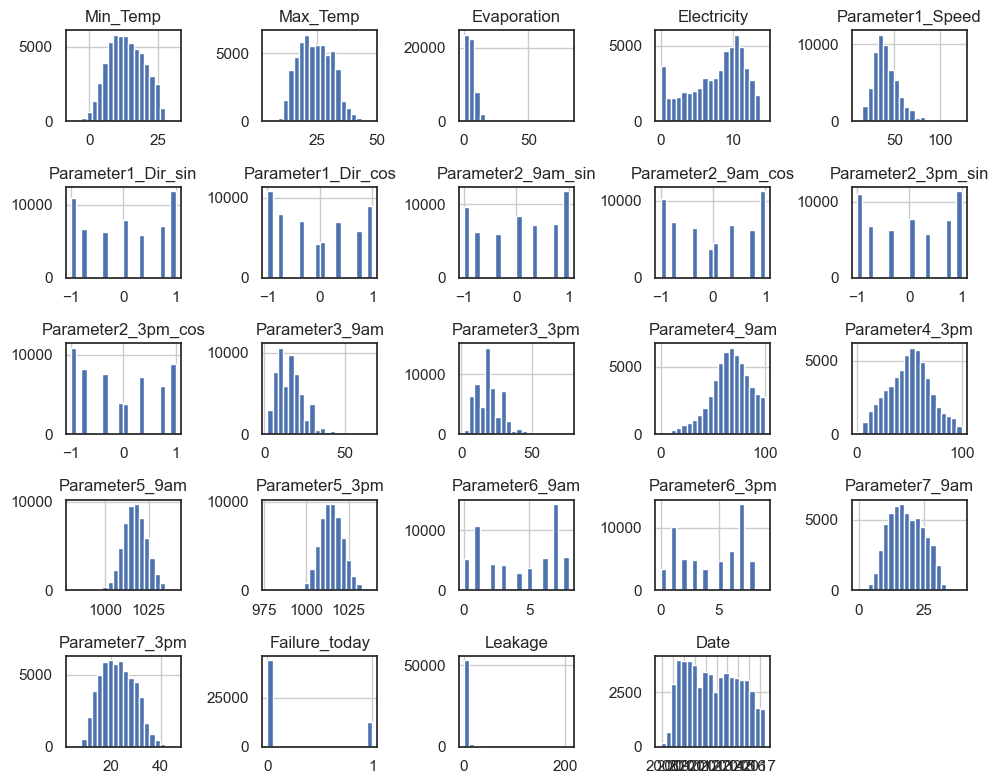

In [209]:
import matplotlib.pyplot as plt
dfrelevante.hist(figsize=(10,8), bins=20)
plt.tight_layout()
plt.show()

In [210]:
#exploración de datos
# for column in dfrelevante.select_dtypes(include=['float64', 'int64']).columns:
#     sns.kdeplot(dfrelevante[column], shade=True, label=column)
#     plt.legend()
#     plt.show()

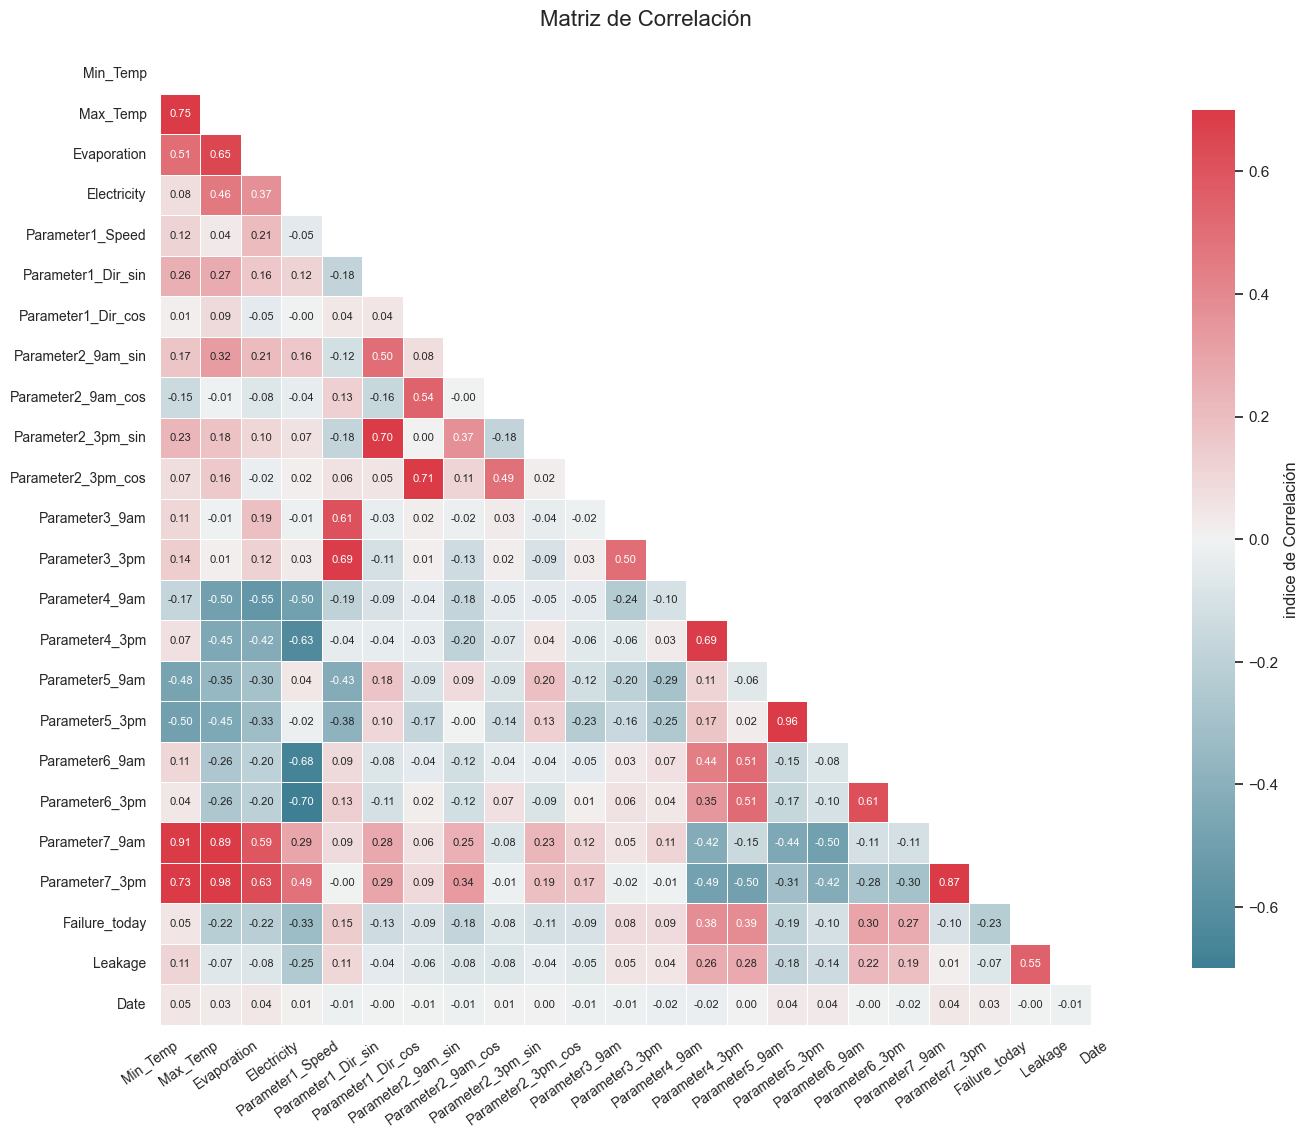

In [211]:
# Calcula la matriz de correlación

df4=dfrelevante
corr = df4.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Estilo de seaborn
sns.set(style="white")

# Tamaño del gráfico
f, ax = plt.subplots(figsize=(14, 12))

# Paleta de colores mejorada
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Mapa de calor
sns.heatmap(
    corr, mask=mask, cmap=cmap, vmax=0.7, vmin=-0.7, center=0, square=True, linewidths=0.4,
    cbar_kws={"shrink": 0.8, 'label': 'indice de Correlación'}, annot=True, fmt=".2f",annot_kws={"size": 8}
)
plt.xticks(rotation=35, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Matriz de Correlación", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

##### En función de esta matriz de correlación, podemos ver que el parametro 7 (9am y 3pm) presentan una correlación alta con otras variables. También asi el parametro 6 (esto sumado a que la variable 6 presnta un gran numero de valores nulos). Otra variable que presenta redundancia al momento de enriquecer el modelo es la de min_Temp, que está altamente correlacionada con su variable alterna que es Max_Temp, Y por ultimo, el parametro5_3pm tiene una alta correlación con parametro5_9am, por lo que se quita para disminuir la multicolinealidad. Tambien es necesario quitar la variable leakage ya que esta esta directamente relacionada con la falla y hasta cierto punto predice el futuro, lo que genera problemas en modelos como Probit.

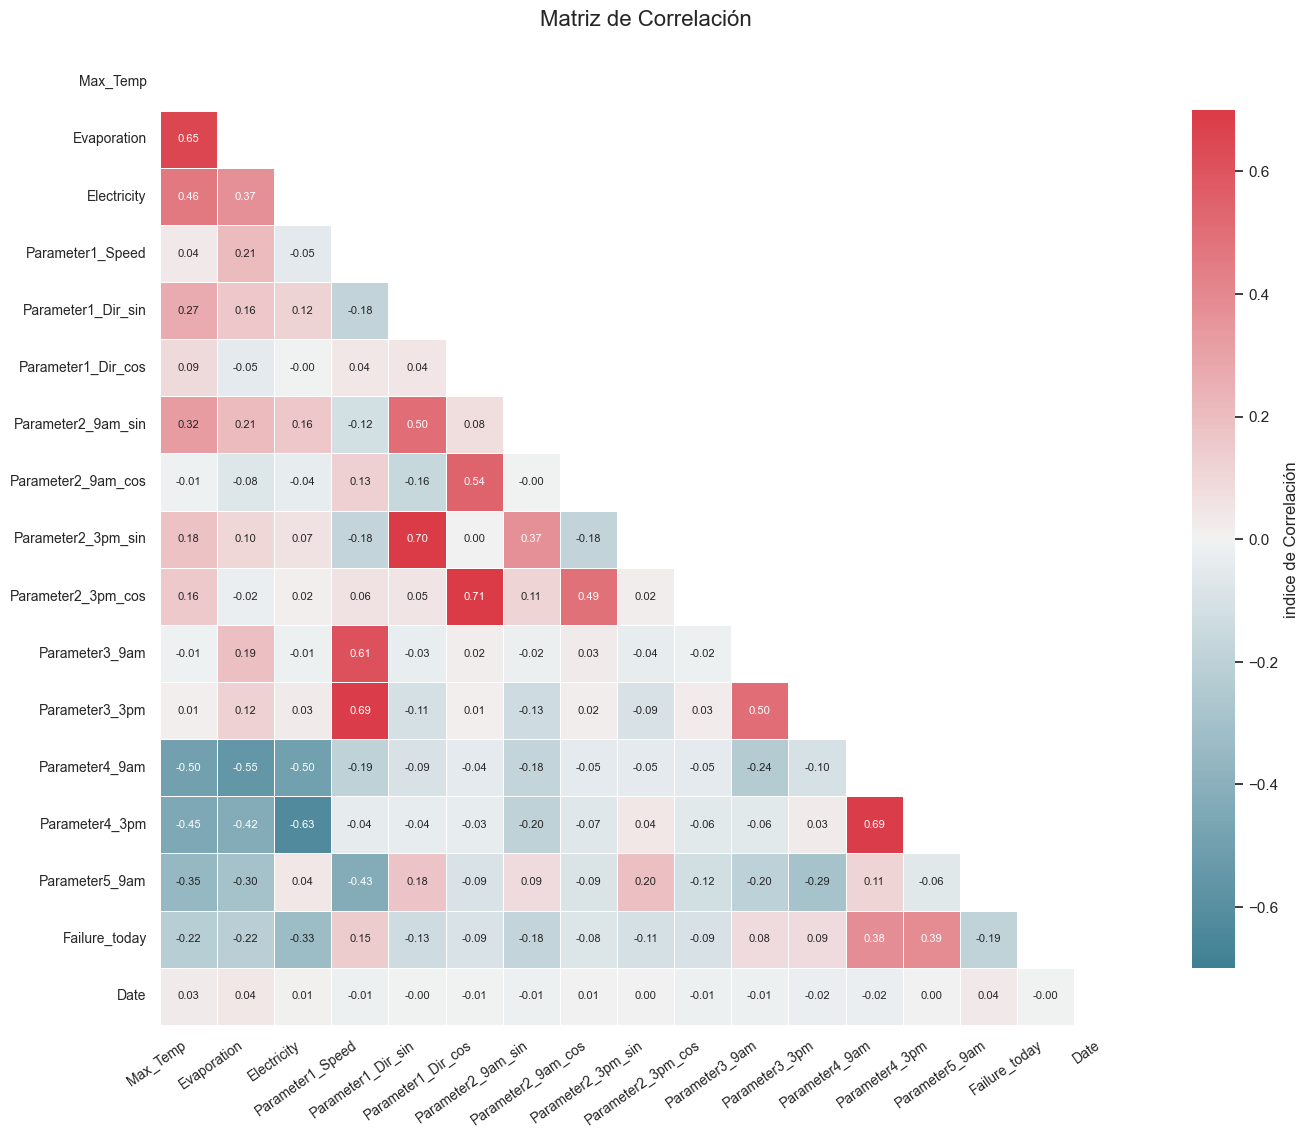

In [212]:
df5 = dfrelevante.drop(columns=[col for col in ['Parameter7_9am','Parameter7_3pm','Parameter6_9am','Parameter6_3pm','Min_Temp','Parameter5_3pm', 'Leakage'] if col in df.columns])

corr = df5.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Estilo de seaborn
sns.set(style="white")

# Tamaño del gráfico
f, ax = plt.subplots(figsize=(14, 12))

# Paleta de colores mejorada
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Mapa de calor
sns.heatmap(
    corr, mask=mask, cmap=cmap, vmax=0.7, vmin=-0.7, center=0, square=True, linewidths=0.4,
    cbar_kws={"shrink": 0.8, 'label': 'indice de Correlación'}, annot=True, fmt=".2f",annot_kws={"size": 8}
)
plt.xticks(rotation=35, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Matriz de Correlación", fontsize=16, pad=20)
plt.tight_layout()
plt.show()
#eliminar la variable dependiente para el analisis de correlacion

In [213]:
df7=df5
#Se calcula el percentil 99 para cada columna
percentil_99 = df7.quantile(0.99)

# Filtrar las filas que están por debajo del percentil 99 en todas las columnas
df7_cleaned = df7[(df7 <= percentil_99).all(axis=1)]

# Verificar la cantidad de datos restantes
print(f"Datos originales: {len(df7)}")
print(f"Datos después de eliminar outliers: {len(df7_cleaned)}")




Datos originales: 56420
Datos después de eliminar outliers: 51948


## 2.-
calculamos la regresión para ver los parametros con la data hasta este punto

In [214]:
import statsmodels.api as sm

# Definir la variable dependiente
y = df7_cleaned['Failure_today']
df6=df7_cleaned.drop(columns=['Failure_today'])
# Definir las variables independientes
X = df6[['Max_Temp', 'Evaporation', 'Electricity', 'Parameter1_Speed', 'Parameter1_Dir_sin', 'Parameter1_Dir_cos', 'Parameter2_9am_sin', 'Parameter2_9am_cos', 'Parameter3_9am', 'Parameter3_3pm', 'Parameter4_9am', 'Parameter4_3pm', 'Parameter5_9am']]
# Agregar una constante al modelo
X = sm.add_constant(X)

# Ajustar el modelo OLS
model = sm.OLS(y, X).fit(cov_type='HC0')

# Mostrar el resumen del modelo
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     1428.
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:21:12   Log-Likelihood:                -20005.
No. Observations:               51948   AIC:                         4.004e+04
Df Residuals:                   51934   BIC:                         4.016e+04
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.8452      0

##### en función de estos datos obtenidos, podemos ver que en este modelo con un coef R2 del 0.259 con un F=1438 y un p-value <0,001 es globalmente significativo por lo que las variables independientes aportan información al comportamiento del sistema y a la predicción de falla.

##### en función de los coeficientes obtenidos, podemos veer que la tempeeratura maxima, la velocidad y los parametros 3_9am, 4_9am, 4_3pm aumentan la probabilidad de falla, mientras que las otras variables la disminuyen.



## 3.-
Ahora para tener otro enfoque, aplicamos el modelo probit que se ajusta mejor a la variable binaria

In [215]:
X2 = X
model = sm.Probit(y, X2)
probit_model = model.fit(cov_type='HC0')
print(probit_model.summary())

mfxp = probit_model.get_margeff()
print(mfxp.summary())

Optimization terminated successfully.
         Current function value: 0.372519
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:                51948
Model:                         Probit   Df Residuals:                    51934
Method:                           MLE   Df Model:                           13
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2906
Time:                        23:21:12   Log-Likelihood:                -19352.
converged:                       True   LL-Null:                       -27277.
Covariance Type:                  HC0   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 40.8697      1.459     28.011      0.000      38.010      43.729
Max_T

Considerando que el modelo probit converge y tiene un p-value 0, este es significativo para interpretaciones

Con esto vemos que los valores con mayor magnitud son los asociados a la dirección del viento, donde tenemos ordenes de hasta el 5% de disminución de probabilidad de falla.

Tambien podemos ver que la temperatura aumenta la probabilidad de falla junto con la velocidad de salida.

In [216]:
X3= X2
model = sm.Logit(y, X3)
logit_model = model.fit(cov_type='HC0')
print(logit_model.summary())

mfxl = logit_model.get_margeff()
print(mfxl.summary())

params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '5%', '95%']
print("Odds Ratios")
print(np.exp(conf).iloc[1:17 , ])

Optimization terminated successfully.
         Current function value: 0.372308
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:                51948
Model:                          Logit   Df Residuals:                    51934
Method:                           MLE   Df Model:                           13
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2910
Time:                        23:21:13   Log-Likelihood:                -19341.
converged:                       True   LL-Null:                       -27277.
Covariance Type:                  HC0   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 71.1818      2.587     27.514      0.000      66.111      76.252
Max_T

### 5.-
| Variable              | OLS (coef) | Logit (dy/dx) | Probit (dy/dx) |
|-----------------------|------------|---------------|----------------|
| Max_Temp              |   0.0018   |    0.0053     |    0.0053      |
| Evaporation           |  -0.0183   |   -0.0177     |   -0.0171      |
| Electricity           |  -0.0073   |   -0.0019     |   -0.0022      |
| Parameter1_Speed      |   0.0053   |    0.0060     |    0.0061      |
| Parameter1_Dir_sin    |  -0.0063   |   -0.0209     |   -0.0216      |
| Parameter1_Dir_cos    |  -0.0358   |   -0.0210     |   -0.0222      |
| Parameter2_9am_sin    |  -0.0258   |   -0.0322     |   -0.0334      |
| Parameter2_9am_cos    |  -0.0457   |   -0.0507     |   -0.0488      |
| Parameter3_9am        |   0.0050   |    0.0039     |    0.0040      |
| Parameter3_3pm        |  -0.0041   |   -0.0027     |   -0.0029      |
| Parameter4_9am        |   0.0058   |    0.0071     |    0.0070      |
| Parameter4_3pm        |   0.0022   |    0.0033     |    0.0034      |
| Parameter5_9am        |  -0.0111   |   -0.0011     |   -0.0011      |




Aunque los tres modelos presentan resultados consistentes en cuanto a la dirección e importancia relativa de las variables, el modelo Logit es el más adecuado para predecir fallas de máquinas en este contexto. Permite estimar probabilidades realistas, facilita la interpretación de los efectos a partir de los odds ratios y se ajusta mejor a la naturaleza binaria del problema. Por lo tanto, usar Logit como modelo de referencia para la interpretación del sistema y toma de desiciones sobre como mejorarlo.


## 6.-


In [217]:
# Extrae año y mes
df7_cleaned['AñoMes'] = df7_cleaned['Date'].dt.to_period('M')

# Lista de variables numéricas EXCLUYENDO las categóricas como las de dirección del viento
vars_numericas = [
    'Max_Temp', 'Evaporation', 'Electricity',
    'Parameter1_Speed','Parameter3_9am','Parameter3_3pm',
    'Parameter4_9am','Parameter4_3pm', 'Parameter5_9am'
    # agrega o ajusta según tu dataset
]

# Agrupa promediando las variables numéricas y contando fallos por mes
df_agregado = df7_cleaned.groupby('AñoMes')[vars_numericas].mean()
df_agregado['Fallos_mes'] = df7_cleaned.groupby('AñoMes')['Failure_today'].sum()

# Si no hubo fallos, Fallos_mes será 0, así que no hace falta más ajustes
df_agregado = df_agregado.reset_index()

In [218]:
import statsmodels.api as sm

# Variables independientes
X = df_agregado[vars_numericas]
X = sm.add_constant(X)           

# Variable dependiente: cantidad de fallos por mes (recuerda: debe ser int >= 0)
y = df_agregado['Fallos_mes']

# Modelo Poisson
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Fallos_mes   No. Observations:                  111
Model:                            GLM   Df Residuals:                      101
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -641.89
Date:                Thu, 24 Apr 2025   Deviance:                       590.03
Time:                        23:24:05   Pearson chi2:                     538.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               26.6680      7.113  